In [7]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import os


class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # List all the image files in the root_dir
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load the image
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # Convert to numpy array and extract the second channel
        image_array = np.array(image)
        second_channel = image_array[:, :, 1]/17  # Keep as is, no need to specify dtype yet
        
        # Convert the second channel to a float tensor
        # The unsqueeze operation adds a channel dimension, making the tensor shape [1, H, W]
        tensor = torch.from_numpy(second_channel).unsqueeze(0).float()

        # Apply transformations if any
        if self.transform:
            tensor = self.transform(tensor)
        return tensor

In [2]:
import numpy as np
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# some nice colors
delft_color = "#00A6D6" # TU Delft light blue color
google_colors = ["#4285F4", # blue
                 "#DB4437", # red
                 "#F4B400", # yellow
                 "#0F9D58"  # green
                 ]


# Custom coloring schemes
COLORS_ROOMTYPE = ['#1f77b4',  # living room
                   '#e6550d',  # master room
                   '#fd8d3c',  # kitchen
                   '#fdae6b',  # bathroom
                   '#fdd0a2',  # dining room
                   '#72246c',  # child room
                   '#5254a3',  # study room
                   '#6b6ecf',  # second room
                   '#2ca02c',  # guest room
                   '#37c837',  # balcony
                   '#1f77b4',  # entrance
                   '#98df8a',  # storage
                   '#d62728',  # walk-in
                   '#e6e6e6',  # external area
                   '#000000',  # exterior wall
                   '#000000',  # front door
                   '#000000',  # interior wall
                   '#ffffff']  # interior door

ROOM_ARRAY_TOGETHER = [[0],
                       [1, 5, 7, 8], # bedroom
                       [2],
                       [3],
                       [4],
                       [6],
                       [9],
                       [10],
                       [11],
                       [12],
                       [13],
                       [14],
                       [15],
                       [16],
                       [17]]

COLORS_ROOMTYPE_REDUC = ['#1f77b4',  # living room
                         '#e6550d',  # bedroom
                         '#fd8d3c',  # kitchen
                         '#fdae6b',  # bathroom
                         '#fdd0a2',  # dining room
                         '#5254a3',  # study room
                         '#37c837',  # balcony
                         '#1f77b4',  # entrance
                         '#98df8a',  # storage
                         '#d62728',  # walk-in
                         '#e6e6e6',  # external area
                         '#000000',  # exterior wall
                         '#000000',  # front door
                         '#000000',  # interior wall
                         '#ffffff']  # interior door

# Color maps
COLOR_MAP_ROOMTYPE = mcolors.ListedColormap(COLORS_ROOMTYPE)
CMAP_ROOMTYPE = get_cmap(COLOR_MAP_ROOMTYPE)

COLOR_MAP_ROOMTYPE_REDUC = mcolors.ListedColormap(COLORS_ROOMTYPE_REDUC)
CMAP_ROOMTYPE_REDUC = get_cmap(COLOR_MAP_ROOMTYPE_REDUC)


# Entity categories and associated classes
CATEGORIES = ["living room",
              "master room",
              "kitchen",
              "bathroom",
              "dining room",
              "child room",
              "study room",
              "second room",
              "guest room",
              "balcony",
              "entrance",
              "storage",
              "walk-in",
              "external area",
              "exterior wall",
              "front door",
              "interior wall",
              "interior door"]

CLASSES = np.arange(0, len(CATEGORIES))

# Floor plan colorization
def colorize_floorplan(img, classes, cmap):

    """
    Colorizes an integer-valued image (multi-class segmentation mask)
    based on a map of classes and colormap.
    """

    h, w = np.shape(img)
    img_c = (np.ones((h, w, 3)) * 255).astype(int)
    for cat in classes:
        color = np.array(cmap(cat))[:3] * 255
        img_c[img == cat, :] = color.astype(int)

    return img_c

def plot_single_floorplan(img):
    """
    Plots a single floor plan image by colorizing, and displaying it.

    Parameters:
    - img: A numpy array representing the floor plan image.

    Returns:
    - fig: The figure object associated with the plot.
    """

    # Load and colorize floor plan image
    img_unique = np.unique(img)
    img_colorized = colorize_floorplan(img, CLASSES, CMAP_ROOMTYPE)

    # Setup figure
    fig, ax = plt.subplots(figsize=(5, 5))  # Use subplots to explicitly create a figure and axes object

    # Create legend
    legend_patches = [mpatches.Patch(color=np.array(CMAP_ROOMTYPE(i)).reshape(1, 4), label=CATEGORIES[i])
                      for i in range(len(CATEGORIES)) if i in img_unique]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Plot image
    ax.imshow(img_colorized)
    ax.set_title("Floor Plan")  # You can make this dynamic if needed
    ax.axis('off')

    return fig  # Return the figure object. You can also return ax if you need access to the axes outside the function.

/tmp/ipykernel_34/2142722846.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  CMAP_ROOMTYPE = get_cmap(COLOR_MAP_ROOMTYPE)
/tmp/ipykernel_34/2142722846.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  CMAP_ROOMTYPE_REDUC = get_cmap(COLOR_MAP_ROOMTYPE_REDUC)


In [3]:
import torch
import torch.nn as nn 
    # Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            nn.MaxPool2d(4, 4),  # Downsample: 256x256 to 128x128
            nn.Flatten(),  # Flatten the output     
            nn.Linear(64*64, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 64*64),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 64, 64)),
            nn.Upsample(scale_factor=4, mode='nearest'),  # Upsample: 32x32 to 64x64
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        latent = self.encoder(x)
        return latent

In [5]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, 3, stride=1, padding=1),  # Keep spatial dimensions: 256x256 to 256x256
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample: 256x256 to 128x128

            nn.Conv2d(2, 4, 3, stride=1, padding=1),  # Keep spatial dimensions: 256x256 to 256x256
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample: 128x128 to 64x64

            nn.Conv2d(4, 8, 3, stride=1, padding=1),  # Keep spatial dimensions: 256x256 to 256x256
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample: 64x64 to 32x32

            nn.Conv2d(8, 16, 3, stride=1, padding=1),  # Keep spatial dimensions: 128x128 to 128x128
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample: 32x32 to 16x16

            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # Keep spatial dimensions: 128x128 to 128x128
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample: 16x16 to 8x8

            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # Keep spatial dimensions: 64x64 to 64x64
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample: 8x8 to 4x4

            nn.Flatten(),  # Flatten the output
            nn.Linear(64 * 4 * 4, 64),  # Reduce to latent representation of size 64
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 64 * 4 * 4),  # Expand from latent space to flattened image
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),  # Unflatten to shape for convolutional layers

            # Upsample and refine
            nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: 32x32 to 64x64
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),

            # Upsample and refine
            nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: 32x32 to 64x64
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: 64x64 to 128x128
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: 64x64 to 128x128
            nn.Conv2d(8, 4, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: 64x64 to 128x128
            nn.Conv2d(4, 2, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: 128x128 to 256x256
            nn.Conv2d(2, 1, 3, stride=1, padding=1),
            nn.Sigmoid()  # Assuming the input images are normalized to [0,1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction
    
    def encode(self, x):
        latent = self.encoder(x)
        return latent

In [8]:
# Create dataset instances
root_dir = '/kaggle/input/original/original'  
dataset = ImageDataset(root_dir, transform=None)

#Define sizes of datasets
dataset_size = len(dataset)  
validation_size = 100
test_size = int(dataset_size * 0.1)
train_size = dataset_size - test_size - validation_size

#Create train, test and valuation datasets
train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_size, test_size, validation_size])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Total dataset size: 80788
Train dataset size: 72610
Test dataset size: 8078
Validation dataset size: 100


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming `Autoencoder` is your model class
model = AE()
model = model.to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer (Adam is a good default choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10 # Number of epochs to train for

def train(model, train_loader, criterion, optimizer, device=device):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc='Training', leave=True)
    for features in progress_bar:
        features = features.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        
        # For an autoencoder, features can act as targets for reconstruction
        loss = criterion(outputs, features)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * features.size(0)
        progress_bar.set_postfix(loss=loss.item())

    average_loss = total_loss / len(train_loader.dataset)
    return average_loss

def evaluate(model, test_loader, criterion, device=device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for features in test_loader:
            features = features.to(device)
            outputs = model(features)
            loss = criterion(outputs, features)  # Use features as targets again
            total_loss += loss.item() * features.size(0)

    average_loss = total_loss / len(test_loader.dataset)
    return average_loss

#Early stopping criteria
min_delta = 0.0001  # Minimum change in the monitored quantity to qualify as an improvement.
patience = 3  # How many epochs to wait after last time the monitored quantity improved.
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    test_loss = evaluate(model, test_loader, criterion)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    # Check if test loss improved
    loss_improvement = best_loss - test_loss
    if loss_improvement > min_delta:
        best_loss = test_loss
        patience_counter = 0  # Reset patience since we have an improvement
    else:
        patience_counter += 1  # No improvement, so increment patience counter

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

print('Finished Training')

# Save the trained model's state_dict
torch.save(model.state_dict(), '/kaggle/working/trained_model_array_CONVAE_900.pth')

Training: 100%|██████████| 1135/1135 [10:15<00:00,  1.85it/s, loss=0.0433]


Epoch 1, Train Loss: 0.0422, Test Loss: 0.0409


Training:  73%|███████▎  | 823/1135 [02:44<01:08,  4.56it/s, loss=0.0242]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1135/1135 [02:34<00:00,  7.35it/s, loss=0.0187]


Epoch 6, Train Loss: 0.0196, Test Loss: 0.0193


Training: 100%|██████████| 1135/1135 [02:31<00:00,  7.49it/s, loss=0.0189]


Epoch 7, Train Loss: 0.0193, Test Loss: 0.0191


Training:  30%|███       | 343/1135 [00:47<01:48,  7.29it/s, loss=0.0185]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1135/1135 [02:37<00:00,  7.22it/s, loss=0.0195]


Epoch 10, Train Loss: 0.0188, Test Loss: 0.0187
Finished Training


In [9]:
class ScoredObject:
    def __init__(self, object_name, score):
        self.object_name = object_name
        self.score = score

    def __repr__(self):
        return f"{self.object_name}: {self.score}"

def get_sort_key(scored_object):
    # Return the score for sorting (lowest first)
    return scored_object.score

def insert_sorted(sorted_list, new_object, key_func):
    # Find the position where the new object should be inserted
    pos = bisect.bisect_left([key_func(item) for item in sorted_list], key_func(new_object))
    sorted_list.insert(pos, new_object)

In [19]:
def image_to_tensor(path):
    target_image = np.array(Image.open(path))
    target_image = target_image[:, :, 1]/17 # Keep as is, no need to specify dtype yet
    target_tensor = torch.from_numpy(target_image).unsqueeze(0).unsqueeze(0).float()
    return target_tensor

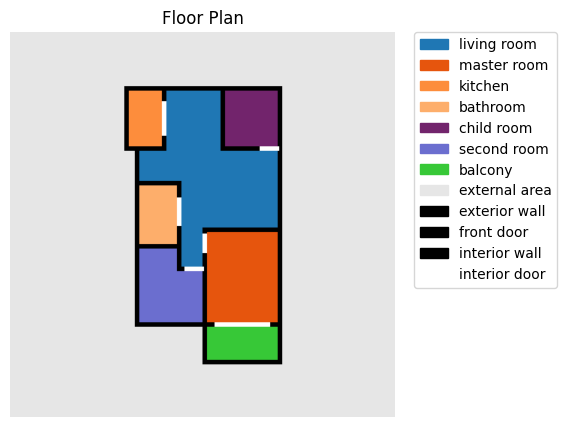

torch.Size([1, 1, 256, 256])


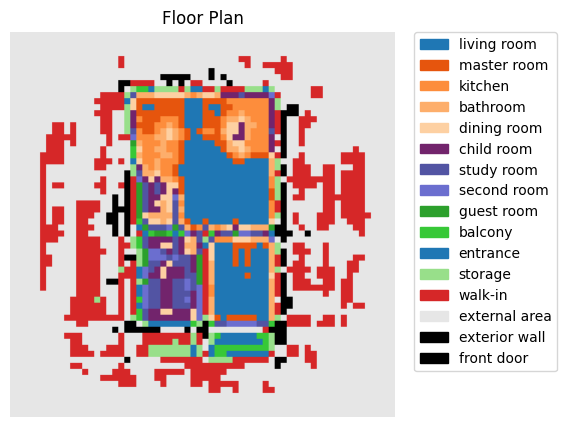

[[13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 ...
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]]
[[13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 ...
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]]


In [9]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AE()
model.load_state_dict(torch.load('/kaggle/input/autoencoder/trained_model_array_AE_900.pth'))

#Open image
image_path = '/kaggle/input/original/original/502.png'
image = Image.open(image_path)
        
#Plot input image
image_array = np.array(image)
image = image_array[:, :, 1] # Keep as is, no need to specify dtype yet
plot_single_floorplan(image)
plt.show()

#Create input tensor
image_norm = image/17
image_tensor = image_norm[np.newaxis, :, :]  
tensor = torch.from_numpy(image_tensor).unsqueeze(0).float()

#Feed tensor through the model
tensor.to(device)
with torch.no_grad():
        output = model(tensor)
        
# Assuming the output is a single-channel image, remove the batch dimension and channel
output_image = output.squeeze().cpu().detach().numpy()  # Add .cpu() for GPU compatibility

# Scale the output back to [0,17] and plot output
np.set_printoptions(threshold=5)
output_img = (17 * output_image).astype(int)
plot_single_floorplan(output_img)
plt.show()



In [13]:
import torch.nn.functional as F

sorted_list = []

#Load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AE()
model.load_state_dict(torch.load('/kaggle/input/autoencoder/trained_model_array_AE_900.pth'))
model.eval()

#Image for which we want to find the best match
target = '/kaggle/input/validation-set/80700.png'
image = Image.open(target)
image_array = np.array(image)
image = image_array[:, :, 1] # Keep as is, no need to specify dtype yet
plot_single_floorplan(image)
plt.show()

#Get latent space of target image
target_tensor = image_to_tensor(target)
target_latent = model.encode(target_tensor)

#Image set to validate with
val_image_indexes = range(80687, 80788)
path = '/kaggle/input/validation-set'

# Correction on the loop and path usage
for i in range(80688, 80788):
    image_path = f'/kaggle/input/validation-set/{i}.png'  # Ensure correct path
    
    # Assuming image_to_tensor correctly prepares your image
    tensor = image_to_tensor(image_path)
    latent_space = model.encode(tensor) 
    
    mse_loss = F.mse_loss(latent_space, target_latent).item()
    insert_sorted(sorted_list, ScoredObject(i, mse_loss), get_sort_key)

winner = sorted_list[1].object_name
image_path = f'/kaggle/input/validation-set/{winner}.png'
image = Image.open(image_path)
image_array = np.array(image)
image = image_array[:, :, 1] # Keep as is, no need to specify dtype yet
plot_single_floorplan(image)
plt.show()


    

NameError: name 'plt' is not defined

In [27]:
import torch.nn.functional as F
import pickle

sorted_list = []

#Load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AE()
model.load_state_dict(torch.load('/kaggle/input/autoencoder/trained_model_array_AE_900.pth'))
model.eval()

#Load triplets data
with open('/kaggle/input/triplets/train_triplets_iou_74K.pickle', 'rb') as file:
    triplets_data = pickle.load(file)

hits = 0
misses = 0
tie = 0
counter = 0

for triplets in triplets_data:
    id_anchor = triplets[0]
    id_positive = triplets[1]
    id_negative = triplets[3]
    
    anchor = image_to_tensor(f'/kaggle/input/original/original/{id_anchor}.png')
    positive = image_to_tensor(f'/kaggle/input/original/original/{id_positive}.png')
    negative = image_to_tensor(f'/kaggle/input/original/original/{id_negative}.png')

    anchor_latent = model.encode(anchor)
    positive_latent = model.encode(positive)
    negative_latent = model.encode(negative)
    
    mse_loss_pos = F.mse_loss(anchor_latent, positive_latent).item()
    mse_loss_neg = F.mse_loss(anchor_latent, negative_latent).item()
    
    if mse_loss_pos < mse_loss_neg:
        hits += 1
    elif mse_loss_pos > mse_loss_neg:
        misses += 1
    else:
        tie += 1
    if counter== 10000:
        break
    counter += 1

print('hits:', hits)
print('misses:', misses)
print('tie:', tie)
print('hitrate:', 100*hits/misses)

8708
1293
0
